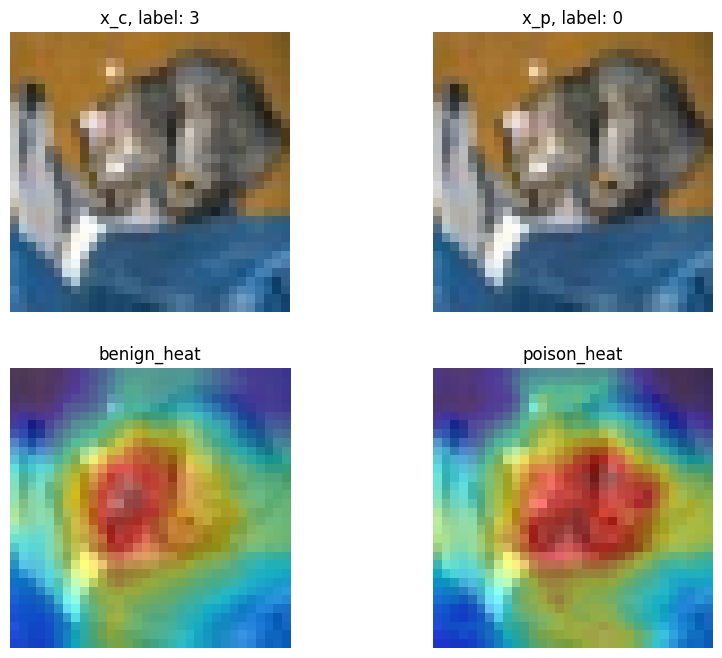

In [28]:
import sys
sys.path.append('../')
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from tools.dataset import get_dataloader
from tools.img import tensor2ndarray
import matplotlib.pyplot as plt
from tools.dataset import get_de_normalization
from omegaconf import OmegaConf, DictConfig
from tools.utils import manual_seed
from models.preact_resnet import PreActResNet18
from tools.inject_backdoor import patch_trigger
import torch
import random

target_folder = '../' + 'results/cifar10/inba/20241006004358_wind1'
path = f'{target_folder}/config.yaml'
config = OmegaConf.load(path)
manual_seed(config.seed)
_, dl = get_dataloader('cifar10', 64, False, 8)
x_benign, x_poison = None, None
device = 'cpu' 
if config.model == "resnet18":
    net = PreActResNet18()
    ld = torch.load(f'{target_folder}/results.pth', map_location=device)
    net.load_state_dict(ld['model'])
else:
    raise NotImplementedError
net.eval()


for x, y in iter(dl):
    x_benign = x
    ground_truth = y
    break

index = random.randint(0, 63) * 0
x_benign = x_benign[index]
ground_truth = ground_truth[index]
x_poison = patch_trigger(get_de_normalization('cifar10')(x_benign).squeeze(), config)

rgb_img = tensor2ndarray(x_benign) / 255.

target_layers = [net.layer4[-1].conv2]
y_clean = net(x_benign.unsqueeze(0))
_, predicted_clean = torch.max(y_clean, -1)
y_poison = net(x_poison.unsqueeze(0))
_, predicted_poison = torch.max(y_poison, -1)

targets = [ClassifierOutputTarget(predicted_clean)]

cam = FullGrad(model=net, target_layers=target_layers)
y_benign = torch.argmax(net(x_benign.unsqueeze(0))[0], dim=0).item()
y_poison = torch.argmax(net(x_poison.unsqueeze(0))[0], dim=0).item()

benign_heat = cam(x_benign.unsqueeze(0),targets=[ClassifierOutputTarget(y_benign)])
poison_heat = cam(x_poison.unsqueeze(0), targets=[ClassifierOutputTarget(y_poison)])

visualization_0 = show_cam_on_image(tensor2ndarray(get_de_normalization('cifar10')(x_benign).squeeze()) / 255., benign_heat[0, :], use_rgb=True)
visualization_1 = show_cam_on_image(tensor2ndarray(x_poison) / 255., poison_heat[0, :], use_rgb=True)

_, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(tensor2ndarray(get_de_normalization('cifar10')(x_benign).squeeze()))
axs[0, 0].set_title(f'x_c, label: {ground_truth}')
axs[0, 0].axis('off')

axs[0, 1].imshow(tensor2ndarray(x_poison))
axs[0, 1].set_title(f'x_p, label: {0}')
axs[0, 1].axis('off')

axs[1, 0].imshow(visualization_0)
axs[1, 0].set_title('benign_heat')
axs[1, 0].axis('off')

axs[1, 1].imshow(visualization_1)
axs[1, 1].set_title('poison_heat')
axs[1, 1].axis('off')
plt.show()